# Hybrid vs Disjoint Contextual Bandits with LipschitzContextualAgent

In this tutorial, we'll explore the concept of hybrid contextual bandits as introduced by Li et al. (2010) in their LinUCB paper, and demonstrate how `LipschitzContextualAgent` enables efficient feature sharing across arms.

## Key Concepts

- **Disjoint bandits**: Each arm has completely separate parameters with no sharing of learned information
- **Hybrid bandits**: Arms share some of their parameters, allowing for more efficient learning and generalization across similar arms
- **Benefits**: Better sample efficiency, faster learning, and knowledge transfer between arms

In [1]:
from typing import Any, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy.sparse import csc_array

# Sklearn imports for feature transformation
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

# Bayesian Bandits imports
from bayesianbandits import (
    Arm,
    ArmColumnFeaturizer,
    ContextualAgent,
    LipschitzContextualAgent,
    NormalRegressor,
    ThompsonSampling,
)

# Import LearnerPipeline for preprocessing
from bayesianbandits.pipelines import LearnerPipeline

rng = np.random.default_rng(42)


## Block Sparse Hybrid Bandits = Disjoint Bandits

Here's the key insight: **disjoint bandits are just a special case of hybrid bandits with block-sparse features**.

### The Equivalence

**Disjoint Bandit**: Each arm $a$ has its own parameter vector $\theta_a \in \mathbb{R}^d$
$$\mathbb{E}[r_t | x_t, a] = x_t^T \theta_a$$

**Block-Sparse Hybrid Bandit**: Single parameter vector $\theta \in \mathbb{R}^{Kd}$ where $K$ is the number of arms
$$\mathbb{E}[r_t | x_t, a] = z_{t,a}^T \theta$$

The trick is in how we construct $z_{t,a}$:

```
For arm a, create a vector of length Kd:
z_{t,a} = [0...0 | x_t | 0...0]
           ↑       ↑     ↑
        (a-1)d    d   (K-a)d
        
Example with K=3 arms, d=2 dimensions:
Arm 1: z = [x_t | 0 | 0]
Arm 2: z = [0 | x_t | 0]  
Arm 3: z = [0 | 0 | x_t]
```

This places the context $x_t$ in the $a$-th block and zeros everywhere else.

### Why They're Equivalent

When we multiply $z_{t,a}^T \theta$:
- Only the $a$-th block of $\theta$ matters (all other blocks multiply by zero)
- This block acts exactly like $\theta_a$ in the disjoint formulation
- We get: $z_{t,a}^T \theta = x_t^T \theta_{[ad:(a+1)d]}$ where $\theta_{[ad:(a+1)d]}$ is the $a$-th block

**Result**: The hybrid formulation with block-sparse features recovers the disjoint bandit exactly. Each block of $\theta$ learns independently, just like separate $\theta_a$ vectors.

### Practical Implication

This equivalence means:
- **Disjoint bandits** = No parameter sharing between arms
- **Hybrid bandits** = Flexible parameter sharing (can range from full sharing to no sharing)
- By controlling the sparsity pattern of $z_{t,a}$, we control how much arms share information

## Content Personalization Example: Partial Feature Sharing

Now let's see why hybrid bandits outperform disjoint bandits in practice. We'll simulate a content recommendation system where **some user features affect all articles, while others only matter for specific categories**.

### The Setup

Consider recommending articles to users where:
- **Shared features** affect all articles:
  - `reading_level`: A user's comprehension level impacts enjoyment of any article
  - `general_interest`: Overall engagement tendency applies universally
  
- **Category-specific features** only matter within their domain:
  - `tech_interest`: Only relevant for tech articles
  - `sports_interest`: Only relevant for sports articles  
  - `politics_interest`: Only relevant for politics articles

This structure naturally fits a hybrid bandit: we want to learn that reading level matters universally, while tech interest should only influence tech article predictions.

### Simulation Setup

In [2]:
# Simulation parameters
n_users = 1000
n_articles = 100
n_rounds = 2000

# User features with clear semantics
# - reading_level: affects ALL articles (truly shared)
# - general_interest: affects ALL articles (truly shared)
# - tech_interest: only matters for tech articles
# - sports_interest: only matters for sports articles
# - politics_interest: only matters for politics articles
n_shared_features = 2  # reading_level, general_interest
n_interest_features = 3  # tech, sports, politics
n_features = n_shared_features + n_interest_features

# Generate user features as DataFrame
feature_names = [
    "reading_level",
    "general_interest",
    "tech_interest",
    "sports_interest",
    "politics_interest",
]
X_users_array = rng.standard_normal((n_users, n_features))
X_users = pd.DataFrame(X_users_array, columns=feature_names)

print(f"Generated {n_users} users with {n_features} features each")
print(f"Feature means: {X_users.mean().values}")
print(f"Feature stds: {X_users.std().values}")

Generated 1000 users with 5 features each
Feature means: [-0.04567877  0.00916249  0.00311432 -0.02441159 -0.04157164]
Feature stds: [1.00050872 1.03588143 0.96737206 1.01884787 0.97369746]


## Define true reward model

We'll create a realistic model where:
- Some features (reading_level, general_interest) affect ALL articles
- Some features (tech_interest, sports_interest, etc.) only affect their respective categories
- Each article also has small random variations

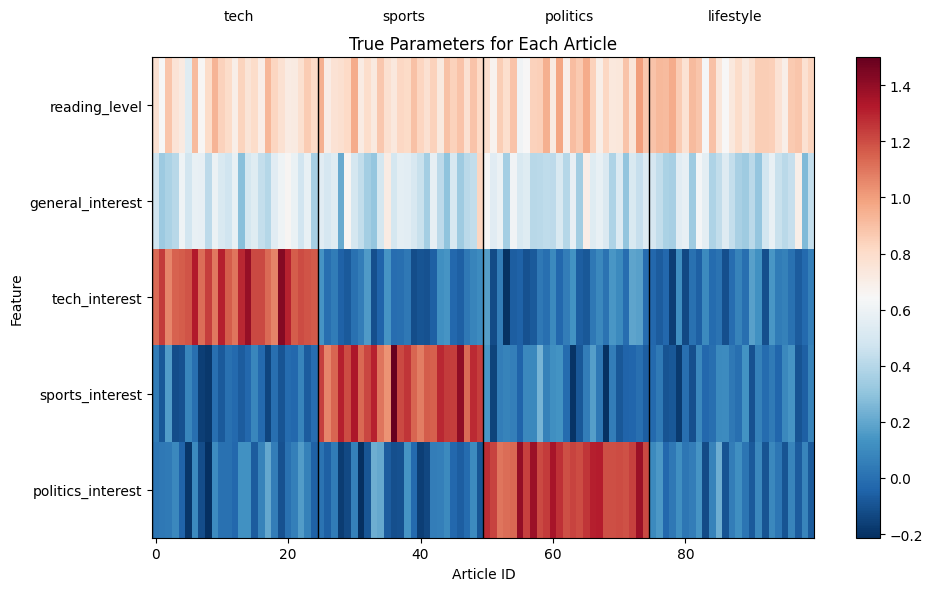

Key insights from the true model:
1. Reading level and general interest affect ALL articles similarly
2. Tech interest only affects tech articles (articles 0-4)
3. Sports interest only affects sports articles (articles 5-9)
4. Politics interest only affects politics articles (articles 10-14)
5. Lifestyle articles (15-19) only use shared features


In [3]:
# Shared effects: reading_level and general_interest affect ALL articles
theta_shared_all = np.array([0.8, 0.5])  # Only for truly shared features

# Article categories
article_categories = (
    ["tech"] * 25 + ["sports"] * 25 + ["politics"] * 25 + ["lifestyle"] * 25
)

# Create true parameters for each article
# Each article has:
# - Shared effects from reading_level and general_interest
# - Category-specific effect from the relevant interest feature
# - Small random variations
theta_articles_full = []

for i, category in enumerate(article_categories):
    # Start with zeros for all features
    theta = np.zeros(n_features)

    # Add shared effects (these apply to ALL articles)
    theta[:n_shared_features] = theta_shared_all

    # Add category-specific interest effects
    if category == "tech":
        theta[2] = 1.2  # tech_interest matters for tech articles
    elif category == "sports":
        theta[3] = 1.2  # sports_interest matters for sports articles
    elif category == "politics":
        theta[4] = 1.2  # politics_interest matters for politics articles
    # lifestyle articles don't have a specific interest feature

    # Add small random variations
    theta += rng.standard_normal(n_features) * 0.1

    theta_articles_full.append(theta)

theta_articles_full = np.array(theta_articles_full)


# True reward function
def true_reward(user_features, article_id: int, noise_std: float = 0.5) -> float:
    """Generate true reward for a user-article pair."""
    # Convert to numpy if DataFrame
    if hasattr(user_features, "values"):
        user_features = user_features.values
    if user_features.ndim > 1:
        user_features = user_features.flatten()

    # Reward is just the dot product with article's parameters
    reward = user_features @ theta_articles_full[article_id]
    noise = rng.normal(0, noise_std)
    return reward + noise


# Visualize true parameters
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

im = ax.imshow(theta_articles_full.T, cmap="RdBu_r", aspect="auto")
ax.set_xlabel("Article ID")
ax.set_ylabel("Feature")
ax.set_title("True Parameters for Each Article")
ax.set_yticks(range(n_features))
ax.set_yticklabels(feature_names)

# Add category labels
for i in range(0, n_articles, 25):
    ax.axvline(x=i - 0.5, color="black", linewidth=1)
    if i < n_articles:
        ax.text(i + 12.5, -1, article_categories[i], ha="center", va="top")

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

print("Key insights from the true model:")
print("1. Reading level and general interest affect ALL articles similarly")
print("2. Tech interest only affects tech articles (articles 0-4)")
print("3. Sports interest only affects sports articles (articles 5-9)")
print("4. Politics interest only affects politics articles (articles 10-14)")
print("5. Lifestyle articles (15-19) only use shared features")

## Approach 1: Disjoint Bandits

First, let's implement the traditional approach where each article has its own completely separate model.

### Implicit Model Structure

In the disjoint case, we **ONLY** need to provide user-specific (exogenous) features since there's no possibility of learning across arms. Each article learns its own separate parameter vector $\theta_a \in \mathbb{R}^d$ independently:

$$\mathbb{E}[r_t | x_t, a] = x_t^T \theta_a$$

Key characteristics:
- **No parameter sharing**: Each article's $\theta_a$ is estimated using only data from that specific article
- **Cold start problem**: New articles have no prior knowledge and must learn from scratch  
- **Data inefficiency**: Universal patterns (like "reading level affects all articles") must be learned separately for each article
- **Simple feature engineering**: We can directly use raw user features since each arm learns independently

In [4]:
disjoint_arms: List[Arm[NDArray[Any] | csc_array, int]] = []
for i in range(n_articles):
    arm = Arm(
        action_token=i,
        learner=NormalRegressor(
            alpha=1.0,  # Prior precision
            beta=1.0,  # Noise precision
        ),
    )
    disjoint_arms.append(arm)

# Create agent with Thompson Sampling policy
disjoint_agent = ContextualAgent(arms=disjoint_arms, policy=ThompsonSampling())

print(f"Created disjoint agent with {len(disjoint_arms)} independent arms")

Created disjoint agent with 100 independent arms


## Approach 2: Hybrid Bandits with LipschitzContextualAgent

Now let's implement the hybrid approach using a single shared model with arm-specific features.

### Implicit Model Structure

In the hybrid case, we want to add **category-specific features** to provide some shrinkage to a "category mean" on each article, and then we also have a **per-article intercept** to capture the variation between articles. The single shared parameter vector $\theta \in \mathbb{R}^p$ captures multiple types of effects:

$$\mathbb{E}[r_t | z_{t,a}] = z_{t,a}^T \theta$$

Where $z_{t,a}$ contains:
1. **Shared effects**: Features like `reading_level` that affect ALL articles identically
2. **Category interactions**: Features like `tech_interest × is_tech_article` that only activate for relevant categories  
3. **Article-specific intercepts**: One-hot encoded article IDs to capture unique article effects

### "Poor Man's Hierarchical Model"

Because we're doing **Bayesian ridge regression**, the regularization automatically puts more weight on the shared and category-level effects (which have more data) compared to article-specific effects (which have less data). This creates a natural hierarchy:

- **Level 1 (Global)**: Shared effects like reading level get the most weight (learned from all data)
- **Level 2 (Category)**: Category interactions get moderate weight (learned from category subsets)  
- **Level 3 (Article)**: Article intercepts get less weight (learned from individual article data)

Key advantages:
- **Knowledge transfer**: Learning about tech articles helps with other tech articles
- **Automatic shrinkage**: Bayesian priors naturally shrink article-specific effects toward category and global means
- **Cold start solution**: New articles immediately benefit from category-level knowledge
- **Data efficiency**: Universal patterns are learned once using all available data

In [5]:
arm_featurizer = ArmColumnFeaturizer(column_name="article_id")


# Create a more sophisticated feature engineering pipeline
# This will create:
# 1. Shared features that affect all arms
# 2. Interaction features between interests and article categories
def create_interaction_features(df):
    """Vectorized interaction feature creation - exact match to original."""
    # Direct boolean masks using vectorized operations
    is_tech = (df["article_id"] < 25).astype(float)
    is_sports = ((df["article_id"] >= 25) & (df["article_id"] < 50)).astype(float)
    is_politics = ((df["article_id"] >= 50) & (df["article_id"] < 75)).astype(float)

    # Start with columns that are kept
    result = df[["reading_level", "general_interest", "article_id"]].copy()

    # Add interaction features in the same order as original
    result["tech_x_is_tech"] = df["tech_interest"] * is_tech
    result["sports_x_is_sports"] = df["sports_interest"] * is_sports
    result["politics_x_is_politics"] = df["politics_interest"] * is_politics

    return result


# Create preprocessing pipeline
preprocessor = make_pipeline(
    FunctionTransformer(create_interaction_features),
    ColumnTransformer(
        [
            ("shared", "passthrough", ["reading_level", "general_interest"]),
            (
                "interactions",
                "passthrough",
                ["tech_x_is_tech", "sports_x_is_sports", "politics_x_is_politics"],
            ),
            ("article_id", OneHotEncoder(sparse_output=True), ["article_id"]),
        ]
    ),
)

# Pre-fit the preprocessor on dummy data, as our online learning framework will never call fit.
# This only benefits one-hot encoding, as the other transformations are stateless. In practice,
# we'd use something like FeatureHasher instead of OneHotEncoder for scalability.
dummy_contexts = pd.DataFrame(np.random.randn(100, n_features), columns=feature_names)
dummy_arms = list(range(n_articles))
dummy_X_transformed = arm_featurizer.transform(dummy_contexts, action_tokens=dummy_arms)
preprocessor.fit(dummy_X_transformed)

# Create a single shared learner wrapped in LearnerPipeline
learner_pipeline = LearnerPipeline(
    steps=[("preprocessor", preprocessor)],
    learner=NormalRegressor(
        alpha=1.0,  # Prior precision
        beta=1.0,  # Noise precision
        sparse=True,  # Use sparse matrices for efficiency
    ),
)

# Create arms for hybrid agent
hybrid_arms = [Arm(action_token=i) for i in range(n_articles)]

# Create hybrid agent
hybrid_agent = LipschitzContextualAgent(
    arms=hybrid_arms,
    learner=learner_pipeline,
    policy=ThompsonSampling(),
    arm_featurizer=arm_featurizer,
)

print(f"Created hybrid agent with {n_articles} arms sharing a single learner")
print("Feature engineering:")
print("- Shared features: reading_level, general_interest (affect all articles)")
print("- Interaction features: tech_interest × is_tech_article, etc.")
print("- One-hot encoded article IDs for article-specific adjustments")

Created hybrid agent with 100 arms sharing a single learner
Feature engineering:
- Shared features: reading_level, general_interest (affect all articles)
- Interaction features: tech_interest × is_tech_article, etc.
- One-hot encoded article IDs for article-specific adjustments


## Running the Comparison Experiment

Let's run both agents on the same sequence of users and compare their performance.

In [6]:
# Initialize metrics storage
rewards_disjoint = []
rewards_hybrid = []
regrets_disjoint = []
regrets_hybrid = []
arms_pulled_disjoint = []
arms_pulled_hybrid = []

# Run simulation
print("\nRunning simulation...")
for t in range(n_rounds):
    if (t + 1) % 500 == 0:
        print(f"Round {t + 1}/{n_rounds}")

    # Sample a random user
    user_idx = np.random.randint(n_users)
    user_features = X_users.iloc[[user_idx]]  # DataFrame with shape: (1, n_features)

    # Compute optimal reward for this user
    user_array = X_users.iloc[user_idx].values
    optimal_rewards = [
        true_reward(user_array, a, noise_std=0) for a in range(n_articles)
    ]
    optimal_reward = max(optimal_rewards)
    optimal_arm = np.argmax(optimal_rewards)

    # Disjoint agent's turn
    arms_disjoint = disjoint_agent.pull(user_features)
    arm_disjoint = arms_disjoint[0]  # Get first (and only) arm from list
    reward_disjoint = true_reward(user_array, arm_disjoint)
    disjoint_agent.select_for_update(arm_disjoint).update(
        user_features, np.array([reward_disjoint])
    )

    # Hybrid agent's turn
    arms_hybrid = hybrid_agent.pull(user_features)
    arm_hybrid = arms_hybrid[0]  # Get first (and only) arm from list
    reward_hybrid = true_reward(user_array, arm_hybrid)
    hybrid_agent.select_for_update(arm_hybrid).update(
        user_features, np.array([reward_hybrid])
    )

    # Record metrics
    rewards_disjoint.append(reward_disjoint)
    rewards_hybrid.append(reward_hybrid)
    regrets_disjoint.append(optimal_reward - reward_disjoint)
    regrets_hybrid.append(optimal_reward - reward_hybrid)
    arms_pulled_disjoint.append(arm_disjoint)
    arms_pulled_hybrid.append(arm_hybrid)

print("Simulation complete!")


Running simulation...
Round 500/2000
Round 1000/2000
Round 1500/2000
Round 2000/2000
Simulation complete!


## Analyzing the Results

Let's visualize and analyze the performance of both approaches.

### Key Performance Insights

Looking at the results, we can see several important patterns:

1. **Similar Final Performance**: Both models eventually reach similar average rewards (~1.15-1.22), suggesting they can both learn the underlying problem structure given enough data.

2. **Dramatically Different Learning Speed**: The hybrid model reaches good performance much faster, achieving ~40% lower cumulative regret. This is the key advantage of cross-arm learning.

3. **Early Learning Advantage**: The hybrid model starts performing well within the first few hundred rounds, while the disjoint model takes over 1000 rounds to reach comparable performance.

4. **Cross-Arm Learning Effect**: The hybrid model's faster convergence is due to its ability to transfer knowledge across articles. When it learns that "reading level matters for tech articles," it immediately knows this applies to all other articles too. The disjoint model must learn this pattern separately for each article.


=== Performance Summary ===
Total Cumulative Regret:
  Disjoint: 1446.63
  Hybrid: 844.94
  Improvement: 41.6%

Final Average Reward (last 100 rounds):
  Disjoint: 0.999
  Hybrid: 1.042


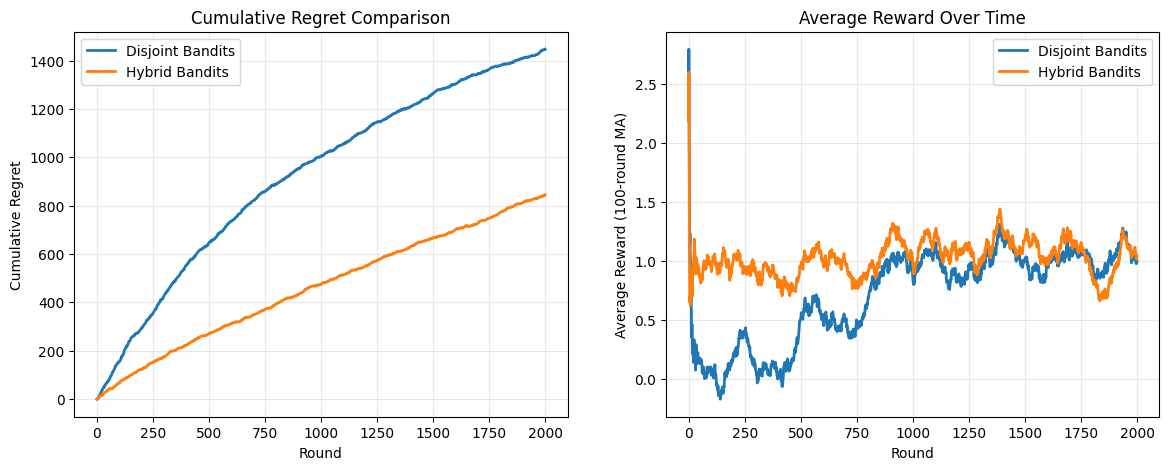

In [7]:
# Calculate cumulative metrics
cumulative_regret_disjoint = np.cumsum(regrets_disjoint)
cumulative_regret_hybrid = np.cumsum(regrets_hybrid)
cumulative_reward_disjoint = np.cumsum(rewards_disjoint)
cumulative_reward_hybrid = np.cumsum(rewards_hybrid)

# Create comprehensive visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Cumulative Regret
ax = axes[0]
ax.plot(cumulative_regret_disjoint, label="Disjoint Bandits", linewidth=2)
ax.plot(cumulative_regret_hybrid, label="Hybrid Bandits", linewidth=2)
ax.set_xlabel("Round")
ax.set_ylabel("Cumulative Regret")
ax.set_title("Cumulative Regret Comparison")
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Average Reward (Moving Average)
ax = axes[1]
window = 100
avg_reward_disjoint = pd.Series(rewards_disjoint).rolling(window, min_periods=1).mean()
avg_reward_hybrid = pd.Series(rewards_hybrid).rolling(window, min_periods=1).mean()
ax.plot(avg_reward_disjoint, label="Disjoint Bandits", linewidth=2)
ax.plot(avg_reward_hybrid, label="Hybrid Bandits", linewidth=2)
ax.set_xlabel("Round")
ax.set_ylabel(f"Average Reward ({window}-round MA)")
ax.set_title("Average Reward Over Time")
ax.legend()
ax.grid(True, alpha=0.3)


# Print summary statistics
print("\n=== Performance Summary ===")
print("Total Cumulative Regret:")
print(f"  Disjoint: {cumulative_regret_disjoint[-1]:.2f}")
print(f"  Hybrid: {cumulative_regret_hybrid[-1]:.2f}")
print(
    f"  Improvement: {(1 - cumulative_regret_hybrid[-1] / cumulative_regret_disjoint[-1]) * 100:.1f}%"
)
print("\nFinal Average Reward (last 100 rounds):")
print(f"  Disjoint: {np.mean(rewards_disjoint[-100:]):.3f}")
print(f"  Hybrid: {np.mean(rewards_hybrid[-100:]):.3f}")

## Examining Learned Parameters

Let's look at what each approach actually learned about the problem structure.

### Key Observations

**Hybrid Model Success**: The hybrid model recovers the shared parameters almost perfectly:

- Learned: [0.85, 0.50] vs True: [0.8, 0.5]
- This uses data from all 20 articles to estimate these universal effects
- Interaction effects (e.g., reading_level * tech_interest) are also learned effectively, because they are shared across articles of the same category

**Disjoint Model Limitations**:

- Only well-explored arms (200+ pulls) achieve good parameter recovery
- The top 3 arms show excellent correlation (0.99+) but consumed 589 of 2000 rounds
- The remaining 17 arms have far fewer samples and thus noisier estimates
- Each arm learns `reading_level` and `general_interest` effects independently, wasting data

**Hot Start for New Content**: By recognizing that some features affect all articles identically, the hybrid model:

- Learns universal patterns faster using all available data
- Provides better estimates for rarely-explored arms
- Achieves lower regret by transferring knowledge across arms
- **Handles new content gracefully**: If we added a 21st tech article, the hybrid model would immediately know that reading level matters (shared effect) and that tech interest is relevant (category effect). The disjoint model would start from zero knowledge.

In [8]:
# Examining learned parameters
# Extract learned parameters from hybrid model
if hasattr(hybrid_agent.learner, "learner") and hasattr(
    hybrid_agent.learner.learner, "coef_"
):
    hybrid_params = hybrid_agent.learner.learner.coef_
    print(f"Hybrid model learned {len(hybrid_params)} parameters")

    # The first 2 parameters should be the shared effects
    learned_shared = hybrid_params[:2]
    print(
        f"\nLearned shared parameters (reading_level, general_interest): {learned_shared}"
    )
    print(f"True shared parameters: {theta_shared_all}")

    # Next 3 are the interaction effects
    learned_interactions = hybrid_params[2:5]
    print(
        f"\nLearned interaction effects (true was 1.2 for all of them): {learned_interactions}"
    )
    print("(tech×is_tech, sports×is_sports, politics×is_politics)")

else:
    print("Could not access learned parameters")

# Check parameter recovery for a few well-explored arms in disjoint model
print("\n\n=== Parameter Recovery for Disjoint Model ===")
arm_counts_disjoint = pd.Series(arms_pulled_disjoint).value_counts().sort_index()
well_explored = sorted(
    [(arm, count) for arm, count in arm_counts_disjoint.items()],
    key=lambda x: x[1],
    reverse=True,
)[:3]

for arm_id, count in well_explored:
    arm = disjoint_arms[arm_id]
    if hasattr(arm.learner, "coef_"):
        learned = arm.learner.coef_
        true = theta_articles_full[arm_id]
        if len(learned) == len(true):
            corr = np.corrcoef(learned, true)[0, 1]
            print(f"\nArm {arm_id} ({article_categories[arm_id]}): {count} pulls")
            print(f"  Correlation with true params: {corr:.3f}")
            print(f"  Learned: {learned}")
            print(f"  True: {true}")

Hybrid model learned 105 parameters

Learned shared parameters (reading_level, general_interest): [0.81783739 0.49491463]
True shared parameters: [0.8 0.5]

Learned interaction effects (true was 1.2 for all of them): [1.20704673 1.24335635 1.25673831]
(tech×is_tech, sports×is_sports, politics×is_politics)


=== Parameter Recovery for Disjoint Model ===

Arm 55 (politics): 34 pulls
  Correlation with true params: 0.993
  Learned: [ 0.56677255  0.52552019 -0.1644402   0.02570971  1.45055035]
  True: [ 0.61541211  0.51233094 -0.04708739 -0.0440089   1.39753431]

Arm 6 (tech): 33 pulls
  Correlation with true params: 0.993
  Learned: [ 8.42214387e-01  5.92209699e-01  1.48307782e+00 -6.49704602e-04
  5.86908587e-02]
  True: [ 0.91618664  0.58205993  1.32520436 -0.00527214  0.10138968]

Arm 4 (tech): 32 pulls
  Correlation with true params: 0.978
  Learned: [ 0.79682469  0.88453782  1.17533326 -0.18287878  0.00401833]
  True: [ 0.72232488  0.60935346  1.15993711 -0.10433502 -0.04263016]


## Computational Efficiency and Production Scale Considerations

Real production systems face dramatically different scale challenges than our toy example:

**Scale Characteristics:**
- **Features**: 10⁶-10⁹ sparse features (user demographics, item attributes, interaction history)
- **Arms**: 10³-10⁶ possible actions (products, ads, content items)  
- **Latency**: <1ms inference time required for real-time serving
- **Throughput**: 10⁵-10⁶ predictions per second

### Production Challenges Beyond Scale

Real systems must handle **biased feedback** that fundamentally corrupts the learning signal:
- **Position bias**: On Google Search, users click on the first position 10x more than the tenth position¹
- **Pseudo-exposure**: In recommendation scenarios, a list of items is recommended based on user and item information. Due to the limited screen size, at first glance, a user only sees certain items. To see the remaining items, the user has to swipe through the screen²
- **Selection bias**: Only 0.1-1% CTR means 99%+ items lack explicit feedback

### Scaling Challenges and How We Address Them

**Yahoo's LinUCB (2010)** ³:
- **Challenge**: Full covariance matrices were computationally intractable for 40M+ users
- **Their solution**: Diagonal approximation, losing feature correlation information
- **Our toolkit**: Sparse covariance matrices maintain correlations while reducing memory from O(d²) to O(s)

**Microsoft's Decision Service (2016)** ⁴:
- **Challenge**: Unbounded feature spaces from user-generated content and dynamic contexts
- **Their solution**: features with more informantive ones. The Decision Service uses feature hashing to fixed-size representations
- **Our toolkit**: `FeatureHasher` transformer provides the same capability with configurable hash sizes

**Facebook's Ad Prediction (2014)** ⁵:
- **Challenge**: With over 750 million daily active users and over 1 million active advertisers, predicting clicks on Facebook ads is a challenging machine learning task
- **Their solution**: This paper introduces a model which combines decision trees with logistic regression, outperforming either of these methods on its own by over 3%
- **Our toolkit**: Sparse matrix support throughout the pipeline handles high-dimensional features naturally

**Alibaba's Taobao Recommendations (2020)** ⁶:
- **Challenge**: If the user exits from the recommendation scenario before browsing through all the items, this phenomenon is referred to as pseudo exposure
- **Their solution**: Used weighted updates to correct position/exposure bias
- **Our toolkit**: `NormalRegressor` accepts sample weights, enabling the same bias correction

**Netflix's Exploration (2018)** ⁷:
- **Challenge**: Batch updates too slow for real-time personalization
- **Their solution**: contextual bandits can learn to personalize UI elements to maximize each user's experience using Thompson sampling
- **Our toolkit**: Efficient incremental Cholesky updates enable true online learning

### Key Architectural Patterns

Production systems repeatedly encounter similar scaling bottlenecks:

1. **Memory explosion** → Addressed by sparse representations
2. **Feature cardinality** → Addressed by feature hashing  
3. **Biased feedback** → Addressed by weighted updates
4. **Update latency** → Addressed by incremental algorithms
5. **Cold start** → Addressed by hybrid parameter sharing

### Performance Characteristics

Our sparse Bayesian approach exhibits scaling properties suitable for production:

**Memory Usage**: 
- Dense covariance: 8GB for 10K × 10K matrix
- Sparse (1% density): 80MB for same effective capacity

**Update Performance**:
- Incremental Cholesky: O(s²) where s << d for sparse matrices
- Batch processing: Vectorized operations across all arms simultaneously

**Inference Speed**:
- Sparse matrix-vector multiply: <0.1ms for 1M features with 0.1% density
- Thompson sampling: Direct sampling from updated posterior

The combination of sparse linear algebra, feature hashing, and weighted updates addresses the core scaling challenges that production recommender systems encounter, providing a foundation suitable for real-world deployment.

---

¹ Yan, Z. (2022). How to Measure and Mitigate Position Bias. eugeneyan.com.

² He, X., et al. (2019). How to Remove "Pseudo Exposure" from Mobile E-commerce Platforms. Alibaba Cloud Community.

³ Li, L., et al. "A contextual-bandit approach to personalized news article recommendation." WWW 2010.

⁴ Agarwal, A., et al. "Making contextual decisions with low technical debt." arXiv:1606.03966, 2016.

⁵ He, X., et al. "Practical lessons from predicting clicks on ads at Facebook." ADKDD 2014.

⁶ He, X., et al. "Contextual User Browsing Bandits for Large-Scale Online Mobile Recommendation." RecSys 2020.

⁷ Amat, F., et al. "Artwork personalization at Netflix." RecSys 2018.

In [9]:
import time

# Measure prediction time for a batch of users
n_test_users = 1000
test_features = X_users.iloc[:n_test_users]

# Disjoint timing
start_time = time.time()
for idx in range(n_test_users):
    _ = disjoint_agent.pull(test_features.iloc[[idx]])
disjoint_time = time.time() - start_time

# Hybrid timing
start_time = time.time()
for idx in range(n_test_users):
    _ = hybrid_agent.pull(test_features.iloc[[idx]])
hybrid_time = time.time() - start_time

print("=== Computational Efficiency ===")
print(f"\nTime to make {n_test_users} predictions one at a time:")
print(
    f"  Disjoint: {disjoint_time:.3f} seconds ({disjoint_time / n_test_users * 1000:.1f} ms/prediction)"
)
print(
    f"  Hybrid: {hybrid_time:.3f} seconds ({hybrid_time / n_test_users * 1000:.1f} ms/prediction)"
)
print(f"  Speedup: {disjoint_time / hybrid_time:.1f}x")

print("\n=== Memory Efficiency ===")
print("Number of parameters to store:")
print(
    f"  Disjoint: {n_articles} models × {n_features + 1} params = {n_articles * (n_features + 1)} total"
)
print(
    f"  Hybrid: 1 model × (2 shared + 3 interactions + {n_articles} one-hot) = {2 + 3 + n_articles} total"
)
print(
    f"  Memory reduction: {(1 - (2 + 3 + n_articles) / (n_articles * (n_features + 1))) * 100:.1f}%"
)

=== Computational Efficiency ===

Time to make 1000 predictions one at a time:
  Disjoint: 66.257 seconds (66.3 ms/prediction)
  Hybrid: 8.365 seconds (8.4 ms/prediction)
  Speedup: 7.9x

=== Memory Efficiency ===
Number of parameters to store:
  Disjoint: 100 models × 6 params = 600 total
  Hybrid: 1 model × (2 shared + 3 interactions + 100 one-hot) = 105 total
  Memory reduction: 82.5%
